In [1]:
!pip install transformers
!pip install sentencepiece

In [2]:
import os
import time
import datetime
import random

import numpy as np
import pandas as pd
import tensorflow as tf
import torch

from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer, AdamW, AutoTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

In [3]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [4]:

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### Format data

In [5]:
base_path = "/content/drive/MyDrive/Colab-data/"

en_train_tweets_file = "english_train_tweets.csv"
# en_test_tweets_file = "english_test_tweets.csv"
ar_tweets_file = "arabic_test_tweets.csv"

# Load the dataset into a pandas dataframe.
en_tweets_df = pd.read_csv(base_path + en_train_tweets_file)
ar_tweets_df = pd.read_csv(base_path + ar_tweets_file)

en_tweets_df['sentiment'].replace({'positive': 1, 'negative': 2, 'neutral': 0}, inplace=True)
ar_tweets_df['sentiment'].replace({'positive': 1, 'negative': 2, 'neutral': 0}, inplace=True)

In [6]:
total_arabic_tweets = ar_tweets_df.shape[0]
train_size = int(0.9 * total_arabic_tweets)

ar_train_df = ar_tweets_df[:train_size]
ar_test_df = ar_tweets_df[train_size:]

print(f"total english tweets {en_tweets_df.shape[0]}")
print(f"total arabic tweets {total_arabic_tweets}")
print(f"train arabic tweets {ar_train_df.shape[0]}")
print(f"test arabic tweets {ar_test_df.shape[0]}")

total english tweets 21124
total arabic tweets 3353
train arabic tweets 3017
test arabic tweets 336


In [7]:
en_tweets_df.sample(10)

,id,sentiment,original,preprocessed
5317,235962031428231168,0,"@DougBenson Leonard Martin category \""""Saturda...","leonard martin category \""""saturday live\ movi..."
1154,262797722409656320,1,"rehearsing for Nov 6 \""""@MlTTR0MNEY: just call...",rehearsing nov 6 called jim leyland congratula...
20500,639656031291879424,2,We've gone from a country that voted UKIP into...,gone country voted ukip 3rd place total votes ...
6749,100001566421037056,2,@YoginiJane while the met may not be perfect w...,met perfect piss like mexico city like tottenham
11721,639228849704804352,1,Grocery delivery services Instacart and Amazon...,grocery delivery services instacart amazon pri...
1352,255548371681562625,0,NTA viewers 7:00am on other tues 10\u002c000 t...,nta viewers 7:00am tues 10\u002c000 viewers tu...
14683,640415532144050176,1,hehhe heres the last of the Hannibal stickers ...,hehhe heres hannibal stickers m making ill reo...
13465,641210718730231808,0,Can anyone imagine someone other than David Ca...,imagine david cameron representing world stage...
16358,641130228631277573,0,"@strngwys @mskerryd A different Robbie. Also, ...",different robbie kerry know brought madelines ...
15921,634388171321671680,2,im so bored i dont want to watch jurassic park...,m bored nt want watch jurassic park hundredth ...


In [8]:
ar_train_df.sample(10)

,id,sentiment,original,preprocessed
855,785993031648317440,1,مقاتلون على منهاج الحسين عليه السلام#الثورة_ال...,مقاتلون على منهاج الحسين عليه السلامالثورة_الح...
2666,785993093300555781,2,الواد لمــا يكبر ح يبقى سيسي .... شوية البزاز...,الواد لمــا يكبر ح يبقى سيسي شوية البزازات دي ...
179,785523326546567168,0,هاتف Nokia D1C يظهر على AnTuTu بنظام أندرويد 7...,هاتف nokia d1c يظهر على antutu بنظام أندرويد 7.0
2429,785992873590288384,2,RT @khalidsaad1398: نايف الشعلان إللي تشتريه ب...,نايف الشعلان إللي تشتريه بالرز يبيعك بالفول مص...
1908,785991618037899264,0,RT @dr_naseer: الطائفية هي أن تبكي على أطفال ح...,الطائفية هي أن تبكي على أطفال حلب في الصباح وت...
2953,785630082551451648,1,@FCBW_A7 @AliwaSasi ممكن حساب ليو ميسي الرسمي 😘,ممكن حساب ليو ميسي الرسمي 😘
1684,784524201042571265,1,@Ylll5 ركبت جستن بيبر كيف ارفه عن نفسي💔🙂,ركبت جستن بيبر كيف ارفه عن نفسي 💔 🙂
1636,785538205642809344,0,@1Kenneddy @khxlidz أغنية بيونسيه ذي,أغنية بيونسيه ذي
401,785628908943212544,2,@ibrahim_ghassan أردوغان المصلحة قبل كل شيء وو...,أردوغان المصلحة قبل كل شيء ووقوفه من قبل مع ال...
1911,785991738188062720,2,RT @1_gentel: نداء الى الاخوة في فتح الشام اتس...,نداء الى الاخوة في فتح الشام اتستراد حماه حلب ...


In [9]:
ar_test_df.sample(10)

,id,sentiment,original,preprocessed
3262,784891485615513600,1,ويندوز 10 احسن من 8 و 8.1 بكتير,ويندوز 10 احسن من 8 و 8.1 بكتير
3050,785993334686744578,0,RT @BarcaDN: الكادينا كوبي: ميسي سوف يتدرب مع ...,الكادينا كوبي ميسي سوف يتدرب مع المجموعة غدا ا...
3106,785761768689762304,1,@SaeedALGhammdi مدينه يعشقهاالسياح لوجود أعلى ...,مدينه يعشقهاالسياح لوجود أعلى قمة uk بن نفيس أ...
3207,784881124489199616,0,@3li_3abdenبحاكي في هيلاري كلنتون 😹😹😹😹😹 https:...,في هيلاري كلنتون 😹 😹 😹 😹 😹
3044,785993254630199297,0,#السعوديه_الاماراتميسي يتابع الصديق والعشير فه...,السعوديه_الاماراتميسي يتابع الصديق والعشير فهد...
3161,782574331066982400,2,RT @WajdWaqfi: عفوا؟ اوباما سحب هيلاري كلنتون ...,عفوا اوباما سحب هيلاري كلنتون معاه هههههه هيلا...
3298,785353535101689856,1,"ترقبوا مفاجأة ويندوز 10 "" في 26 اكتوبر الجاري...",ترقبوا مفاجأة ويندوز 10 في 26 اكتوبر الجاري مش...
3122,785864242058625024,0,قفشت الوله هاري بوتر المصري فالتليفزيون https:...,قفشت الوله هاري بوتر المصري فالتليفزيون
3173,782935682889187328,0,اللي رفضوا حكم الإخوان هما اللي عاوزين هيلاري ...,اللي رفضوا حكم الإخوان هما اللي عاوزين هيلاري ...
3343,785890710071418880,2,@PlayStationSA @Xbox_Saudi مافيه اي عذر لمايكر...,مافيه اي عذر لمايكرو ويندوز 10 مٌعرب وفي الاكس...


#### Define Helper functions

In [10]:
def tokenize_sentences(sentences, labels, tokenizer):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

In [11]:
def train_val_split(input_ids, attention_masks, labels):
  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Create a 90-10 train-validation split.

  # Calculate the number of samples to include in each set.
  train_size = int(0.9 * len(dataset))
  val_size = len(dataset) - train_size

  # Divide the dataset by randomly selecting samples.
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

  return train_dataset, val_dataset, train_size, val_size

In [12]:
def get_data_loaders(train_dataset, val_dataset, batch_size = 32):
  # The DataLoader needs to know our batch size for training, so we specify it 
  # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
  # size of 16 or 32.
  # batch_size = 32

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  return train_dataloader, validation_dataloader

In [13]:
epochs = 4

def get_lr_scheduler(train_dataloader):

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  return scheduler

In [14]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
def train(model, epochs, train_dataloader, validation_dataloader, scheduler, seed_val=42):
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Set the seed value all over the place to make this reproducible.
  # seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 80 batches.
          if step % 80 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward` 
          # function and pass down the arguments. The `forward` function is 
          # documented here: 
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the 
          # output values prior to applying an activation function like the 
          # softmax.
          loss = result.loss
          logits = result.logits
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return training_stats

In [17]:
def format_training_stats(training_stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # A hack to force the column headers to wrap.
  #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

  # Display the table.
  return df_stats

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

def plot_traing_val_loss(df_stats):
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()

In [19]:
def prepare_test_dataset(sentences, labels, batch_size=16):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  return prediction_data, prediction_sampler, prediction_dataloader

In [20]:
def generate_test_predictions(model, prediction_dataloader):
  # Prediction on test set

  # print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask,
                      return_dict=True)
    # print(result)
    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  print('DONE.')
  return predictions , true_labels

In [21]:
def calculate_accuracy(predictions, true_labels):
  # Combine the results across all batches. 
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 , 1, 2) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  acc = np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)
  return acc



## Finetuning with English tweets

#### Model Setup

In [22]:
# Load the tokenizer. 
# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=True)
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=True)
# Load the model.
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()
print('done')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

done


In [23]:
sentences = en_tweets_df.preprocessed.values
labels = en_tweets_df.sentiment.values

#### Fine-tuning the model 

In [24]:
input_ids, attention_masks, labels = tokenize_sentences(sentences, labels, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  gas house hit $ 3.39 i\u2019 m going chapel hill sat
Token IDs: tensor([     0,   9060,  18276,   5962,   3650,   1031,   9323,     17,  41872,
            34,  32196,    347,   7730,   1608,   5310, 130473,  11736,      2,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])


In [25]:
train_dataset, val_dataset, train_size, val_size = train_val_split(input_ids, attention_masks, labels)
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

19,011 training samples
2,113 validation samples


In [26]:
train_dataloader, validation_dataloader = get_data_loaders(train_dataset, val_dataset)

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [28]:
scheduler = get_lr_scheduler(train_dataloader)

In [29]:
training_stats = train(model, epochs, train_dataloader, validation_dataloader, scheduler, seed_val=42)


======== Epoch 1 / 4 ========
Training...
  Batch    80  of    595.    Elapsed: 0:00:19.
  Batch   160  of    595.    Elapsed: 0:00:38.
  Batch   240  of    595.    Elapsed: 0:00:57.
  Batch   320  of    595.    Elapsed: 0:01:16.
  Batch   400  of    595.    Elapsed: 0:01:35.
  Batch   480  of    595.    Elapsed: 0:01:53.
  Batch   560  of    595.    Elapsed: 0:02:12.

  Average training loss: 0.88
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.64
  Validation Loss: 0.83
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    80  of    595.    Elapsed: 0:00:19.
  Batch   160  of    595.    Elapsed: 0:00:38.
  Batch   240  of    595.    Elapsed: 0:00:57.
  Batch   320  of    595.    Elapsed: 0:01:16.
  Batch   400  of    595.    Elapsed: 0:01:35.
  Batch   480  of    595.    Elapsed: 0:01:53.
  Batch   560  of    595.    Elapsed: 0:02:12.

  Average training loss: 0.76
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.66
 

In [30]:
df_stats = format_training_stats(training_stats)
df_stats.head()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.88,0.83,0.64,0:02:20,0:00:04
2,0.76,0.77,0.66,0:02:20,0:00:04
3,0.67,0.79,0.66,0:02:20,0:00:04
4,0.61,0.80,0.66,0:02:20,0:00:04


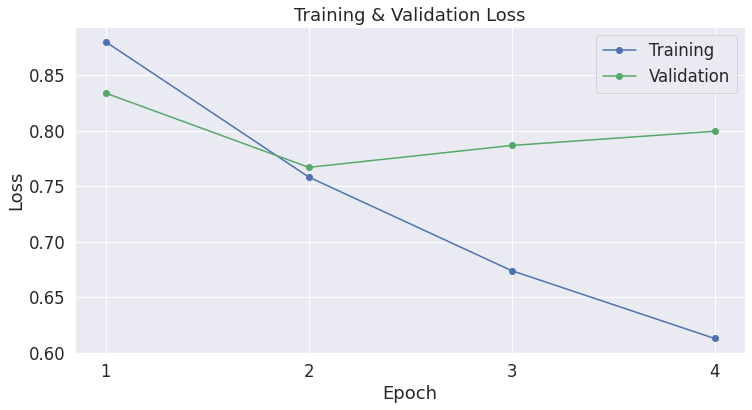

In [31]:
plot_traing_val_loss(df_stats)

In [32]:
# Create sentence and label lists
sentences = ar_test_df.preprocessed.values
labels = ar_test_df.sentiment.values

prediction_data, prediction_sampler, prediction_dataloader = prepare_test_dataset(sentences, labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [33]:
predictions , true_labels = generate_test_predictions(model, prediction_dataloader)

DONE.


In [34]:
acc = calculate_accuracy(predictions , true_labels)
print(str('Accuracy: {:04.4f}'.format(acc*100))+'%')

Accuracy: 53.2738%


## Finetuning with English and Arabic tweets 

#### Model Setup

In [35]:
train_df = pd.concat([en_tweets_df, ar_train_df], axis=0, ignore_index=True)

print(f"total train tweets {train_df.shape[0]}")
print(f"total test tweets {ar_tweets_df.shape[0]}")

total train tweets 24141
total test tweets 3353


In [36]:
# Load the tokenizer. 
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base", do_lower_case=True)

# Load the model.
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", 
    num_labels = 3, # The number of output labels--3 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
# Tell pytorch to run this model on the GPU.
model.cuda()
print('done')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

done


In [37]:
sentences = train_df.preprocessed.values
labels = train_df.sentiment.values

In [38]:
input_ids, attention_masks, labels = tokenize_sentences(sentences, labels, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  gas house hit $ 3.39 i\u2019 m going chapel hill sat
Token IDs: tensor([     0,   9060,  18276,   5962,   3650,   1031,   9323,     17,  41872,
            34,  32196,    347,   7730,   1608,   5310, 130473,  11736,      2,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])


In [39]:
train_dataset, val_dataset, train_size, val_size = train_val_split(input_ids, attention_masks, labels)
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

21,726 training samples
2,415 validation samples


#### Fine-tuning the model 

In [40]:
train_dataloader, validation_dataloader = get_data_loaders(train_dataset, val_dataset)

In [41]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [42]:
scheduler = get_lr_scheduler(train_dataloader)

In [43]:
training_stats = train(model, epochs, train_dataloader, validation_dataloader, scheduler, seed_val=42)


======== Epoch 1 / 4 ========
Training...
  Batch    80  of    679.    Elapsed: 0:00:19.
  Batch   160  of    679.    Elapsed: 0:00:38.
  Batch   240  of    679.    Elapsed: 0:00:57.
  Batch   320  of    679.    Elapsed: 0:01:16.
  Batch   400  of    679.    Elapsed: 0:01:35.
  Batch   480  of    679.    Elapsed: 0:01:53.
  Batch   560  of    679.    Elapsed: 0:02:12.
  Batch   640  of    679.    Elapsed: 0:02:31.

  Average training loss: 0.89
  Training epcoh took: 0:02:40

Running Validation...
  Accuracy: 0.64
  Validation Loss: 0.79
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    80  of    679.    Elapsed: 0:00:19.
  Batch   160  of    679.    Elapsed: 0:00:38.
  Batch   240  of    679.    Elapsed: 0:00:57.
  Batch   320  of    679.    Elapsed: 0:01:16.
  Batch   400  of    679.    Elapsed: 0:01:35.
  Batch   480  of    679.    Elapsed: 0:01:53.
  Batch   560  of    679.    Elapsed: 0:02:12.
  Batch   640  of    679.    Elapsed: 0:02:31.

  Averag

In [44]:
df_stats = format_training_stats(training_stats)
df_stats.head()

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.89,0.79,0.64,0:02:40,0:00:05
2,0.75,0.77,0.66,0:02:40,0:00:05
3,0.66,0.78,0.66,0:02:40,0:00:05
4,0.60,0.80,0.66,0:02:40,0:00:05


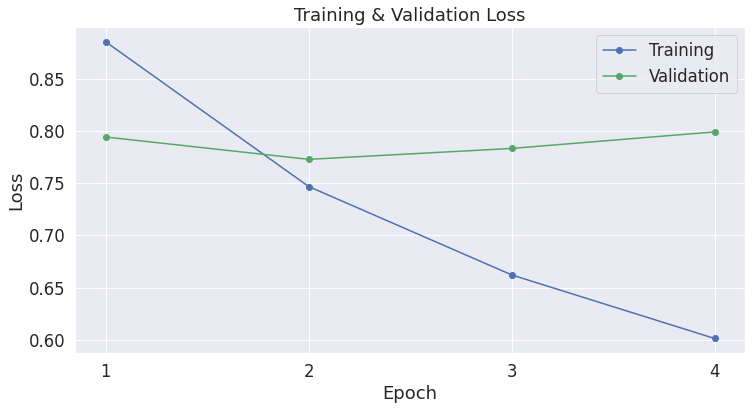

In [45]:
plot_traing_val_loss(df_stats)

In [46]:
# Create sentence and label lists
sentences = ar_test_df.preprocessed.values
labels = ar_test_df.sentiment.values

prediction_data, prediction_sampler, prediction_dataloader = prepare_test_dataset(sentences, labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [47]:
predictions , true_labels = generate_test_predictions(model, prediction_dataloader)

DONE.


In [48]:
acc = calculate_accuracy(predictions , true_labels)
print(str('Accuracy: {:04.4f}'.format(acc*100))+'%')

Accuracy: 61.0119%
